In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 01 - Dataset

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from google.colab.patches import cv2_imshow

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Do_an/CV_Nang_Cao/"

# IMAGES_DIR = os.path.join(BASE_DIR, "images")

# RESIZED_224x224DIR = os.path.join(BASE_DIR, "Resized_224x224")
# FULL_TRAIN_DIR = os.path.join(RESIZED_224x224DIR, "Full_train")
# TRAIN_DIR = os.path.join(RESIZED_224x224DIR, "train")
# TEST_DIR = os.path.join(RESIZED_224x224DIR, "test")

CANNY_RESIZED_224x224DIR = os.path.join(BASE_DIR, "Crop_with_Canny")
TRAIN_DIR = os.path.join(CANNY_RESIZED_224x224DIR, "Train_Resized_224x224")
TEST_DIR = os.path.join(CANNY_RESIZED_224x224DIR, "Test_Resized_224x224")


MODEL_DIR = os.path.join(BASE_DIR, "Models")
TRAIN_CSV_FILEPATH = os.path.join(BASE_DIR, "train.csv")
SAMPLE_SUBMIT_FILEPATH = os.path.join(BASE_DIR, "sample_submission.csv")

CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))

In [ ]:
# nsamples_class_healthy = len(os.listdir(os.path.join(TRAIN_DIR, "healthy")))
# nsamples_class_multiple_diseases = len(os.listdir(os.path.join(TRAIN_DIR, "multiple_diseases")))
# nsamples_class_rust = len(os.listdir(os.path.join(TRAIN_DIR, "rust")))
# nsamples_class_scab = len(os.listdir(os.path.join(TRAIN_DIR, "scab")))

# print(f"Classes: {CLASS_NAMES}")
# print("Number of samples per class:")
# print(f"Healthy: {nsamples_class_healthy}")
# print(f"Multiple diseases: {nsamples_class_multiple_diseases}")
# print(f"Rust: {nsamples_class_rust}")
# print(f"Scab: {nsamples_class_scab}")

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
        directory=TRAIN_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 1821 images belonging to 4 classes.


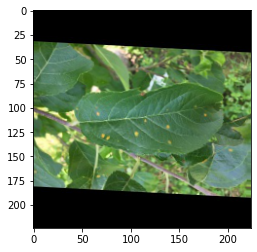

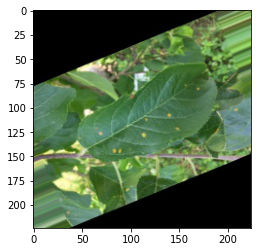

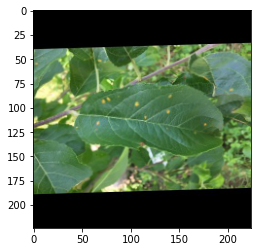

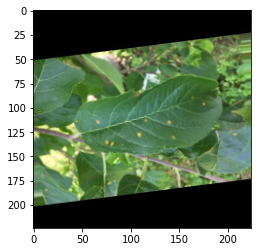

In [ ]:
# from keras.preprocessing import image

# fnames = [os.path.join(TRAIN_DIR + "/rust", fname) for
#      fname in os.listdir(TRAIN_DIR + "/rust")]

# img_path = fnames[3]

# img = image.load_img(img_path, target_size=(224, 224))

# x = image.img_to_array(img)
# x = x.reshape((1,) + x.shape)

# i = 0
# for batch in train_datagen.flow(x, batch_size=1):
#     plt.figure(i)
#     imgplot = plt.imshow(image.array_to_img(batch[0]))
#     i += 1
#     if i % 4 == 0:
#         break

# plt.show()

In [ ]:
def read_test_data():
    test_data = np.zeros(shape=(1821, 224, 224, 3), dtype=np.float32)

    for index, file_name in enumerate(os.listdir(TEST_DIR)):
        file_path = os.path.join(TEST_DIR, file_name)
        img = cv2.imread(file_path)
        test_data[index] = img

        # cv2_imshow(img)
        # cv2_imshow(test_data[index])
        if index % 100 == 0:
            print(f"Loaded {index} images")

    test_data = test_data/255.0

    return test_data

In [ ]:
# This function is used to load train data, to work with K-fold cross validation
# def read_train_data():
#     train_df = pd.read_csv(TRAIN_CSV_FILEPATH)
#     data_top = train_df.head(1821)

#     datas = np.zeros(shape=(1821, 224, 224, 3), dtype=np.float32)
#     labels = np.zeros(shape=(1821), dtype=np.float32)

#     for index in data_top.index:
#         filename = train_df['image_id'][index]

#         class_foldername = ''
#         for classname in ['healthy', 'multiple_diseases', 'rust', 'scab']:
#             if train_df[classname][index] == 1:
#                 class_foldername = classname
#                 break
#         if class_foldername == '':
#             raise Exception(f"Can't found class for image: {filename}")

#         class_dir = os.path.join(TRAIN_DIR, class_foldername)
#         img_path = os.path.join(class_dir, f"{filename}.jpg")

#         datas[index] = cv2.imread(img_path)
#         if class_foldername == 'healthy':
#             # labels.append(0)
#             labels[index] = 0
#         elif class_foldername == 'multiple_diseases':
#             # labels.append(1)
#             labels[index] = 1
#         elif class_foldername == 'rust':
#             # labels.append(2)
#             labels[index] = 2
#         elif class_foldername == 'scab':
#             # labels.append(3)
#             labels[index] = 3


#         # if index == 299:
#         #     break

#     datas = datas/255.0
#     # labels = lb.fit_transform(labels)

#     return datas, labels

In [ ]:
# for data_batch, labels_batch in train_generator:
#     print("data batch shape:", data_batch.shape)
#     print("labels batch shape:", labels_batch.shape)
#     break

In [ ]:
def model_with_convbase_VGG16(model, trainable_type):
    conv_base = VGG16(weights="imagenet",
                      include_top=False,
                      input_shape=(224, 224, 3)
    )
    conv_base.trainable = trainable_type

    # for layer in conv_base.layers[0:15]:
    #     layer.trainable = False

    # for layer in conv_base.layers[15:]:
    #     layer.trainable = True

    model.add(conv_base) # output là một khối đặc trưng 3D, vd: (3000, 3000, 64)
    model.add(layers.Flatten()) # classification layer cần input là một vector nên cần phải reshape khối 3D trên, vd: (3000, 3000, 64) thành (3000* 3000* 64)
    # model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    return model

In [ ]:
def model_with_convbase_VGG19(model, trainable_type):
    conv_base = VGG19(weights="imagenet",
                      include_top=False,
                      input_shape=(224, 224, 3)
    )
    conv_base.trainable = trainable_type

    # for layer in conv_base.layers[0:15]:
    #     layer.trainable = False

    # for layer in conv_base.layers[15:]:
    #     layer.trainable = True

    model.add(conv_base) # output là một khối đặc trưng 3D, vd: (3000, 3000, 64)
    model.add(layers.Flatten()) # classification layer cần input là một vector nên cần phải reshape khối 3D trên, vd: (3000, 3000, 64) thành (3000* 3000* 64)
    # model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    return model

In [ ]:
def model_example_in_book(model):
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    # model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    return model

In [ ]:
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()

In [ ]:
def save_model_and_result(result, model, model_save_name):
    model_name = model_save_name
    new_model_path = os.path.join(MODEL_DIR, model_name)

    sub = pd.read_csv(SAMPLE_SUBMIT_FILEPATH)

    sub.loc[:, 'healthy':] = result
    sub.to_csv(model_name + '.csv', index=False)    # Save here for quick view result
    sub.head()

    os.mkdir(new_model_path)

    sub.to_csv(f"{new_model_path}/{model_name}.csv", index=False)   # Save in the same folder with model
    file_model = os.path.join(new_model_path, f"{model_name}_model.h5")
    model.save(file_model)

    print("Model and result saved")

In [ ]:


def run_model(model_type, trainable_type, model_name):

    model = models.Sequential()
    if model_type == "VGG16":
        model = model_with_convbase_VGG16(model, trainable_type)
    elif model_type == "VGG19":
        model = model_with_convbase_VGG19(model, trainable_type)
    elif model_type == "Example_in_book":
        model = model_example_in_book(model)
    else:
        raise Exception(f"Something went wrong with model_type parameter !!!")

    print(f"Model type: {model_type}")

    model.summary()

    model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5), #optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                multi_label=False)]
    )

    print(f"Learning rate: {backend.eval(model.optimizer.lr)}")

    print('Start training\n')
    history = model.fit(
            train_generator,
            steps_per_epoch=1821//32,
            epochs=10
    )

    result = model.predict(test_data, verbose=1)

    print(f"\nShape of result: {result.shape}")

    save_model_and_result(result, model, model_save_name=model_name)
    print(f"Model {model_name} saved")

    # plot_accuracy_and_loss(history)

    print("Run completed")

In [ ]:
# import time

# start_time = time.time()    # start time
# test_data = read_test_data()
# end_time = time.time()      # end time

# print(f"Time to load test data: {end_time - start_time}s")

Loaded 0 images
Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Loaded 500 images
Loaded 600 images
Loaded 700 images
Loaded 800 images
Loaded 900 images
Loaded 1000 images
Loaded 1100 images
Loaded 1200 images
Loaded 1300 images
Loaded 1400 images
Loaded 1500 images
Loaded 1600 images
Loaded 1700 images
Loaded 1800 images
Time to load test data: 438.23971343040466s


In [ ]:
# run_model(model_type="Example_in_book",
#           trainable_type=None,
#           model_name="Example_in_book_10_epochs_lr1e_5_ResizedVer_notAllLayers_AUC_final"
# )

Model type: Example_in_book
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                11944000  
_________________________________________________________________
dense_3 (Dense)           

In [ ]:
# run_model(model_type="VGG16",
#           trainable_type=False,
#           model_name="VGG16_freeze_10_epochs_lr1e_5_ResizedVer_noDense256_AUC_final"
# )

In [ ]:
# run_model(model_type="VGG19",
#           trainable_type=False,
#           model_name="VGG19_freeze_10_epochs_lr1e_5_ResizedVer_noDense256_AUC_final"
# )

In [ ]:
# run_model(model_type="VGG16",
#           trainable_type=False,
#           model_name="VGG16_freeze_10_epochs_lr1e_5_CannyResizedVer_dense256_AUC_final"
# )

In [ ]:
# run_model(model_type="VGG19",
#           trainable_type=False,
#           model_name="VGG19_freeze_10_epochs_lr1e_5_CannyResizedVer_dense256_AUC_final"
# )

In [ ]:
# run_model(model_type="Example_in_book",
#           trainable_type=None,
#           model_name="Example_in_book_10_epochs_lr1e_5_CannyResizedVer_left2layers_AUC_final"
# )

In [ ]:
def resize_and_pad(img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size
    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA

    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = float(w)/h 
    saspect = float(sw)/sh

    if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0

    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

# img = resizeAndPad(img, size=(300, 300), padColor=0)
# cv2_imshow(img)

In [ ]:
def crop_img(img):
    # img = cv2.imread(path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))

    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    
    crop_img = img[row_min:row_max, col_min:col_max]
    # plt.imshow(crop_img)

    return crop_img

In [ ]:
from keras.models import load_model

VGG16_model_name = "VGG16_freeze_10_epochs_lr1e_5_ResizedVer_noDense256_AUC_final"
VGG19_model_name = "VGG19_freeze_10_epochs_lr1e_5_ResizedVer_noDense256_AUC_final"
example_org_model_name = "Example_in_book_10_epochs_lr1e_5_ResizedVer_org_final"
example_modified_model_name = "Example_in_book_10_epochs_lr1e_5_ResizedVer_modified_final"

VGG16_model_path = os.path.join(MODEL_DIR, f"{VGG16_model_name}/{VGG16_model_name}_model.h5")
VGG19_model_path = os.path.join(MODEL_DIR, f"{VGG19_model_name}/{VGG19_model_name}_model.h5")
example_org_model_path = os.path.join(MODEL_DIR, f"{example_org_model_name}/{example_org_model_name}_model.h5")
example_modified_model_path = os.path.join(MODEL_DIR, f"{example_modified_model_name}/{example_modified_model_name}_model.h5")

In [ ]:
model = load_model(VGG16_model_path)

In [ ]:
img_path = os.path.join(TEST_DIR, "Test_1.jpg")

img = cv2.imread(img_path)
imgs = np.zeros(shape=(1, 224, 224, 3), dtype=np.float32)
imgs[0] = img
probs = model.predict(imgs[0:1])


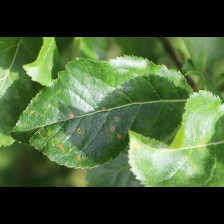

[[9.9729139e-01 1.4663452e-10 3.4458722e-07 2.7082276e-03]]


In [ ]:
cv2_imshow(img)
print(probs)

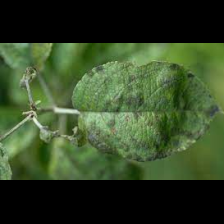

[[2.9688206e-16 8.7250793e-17 7.6743186e-12 1.0000000e+00]]


In [ ]:
img_path = "/content/anh_test_thu_nghiem.jpg"
img = cv2.imread(img_path)
img = crop_img(img)
img = resize_and_pad(img, size=(224, 224), padColor=0)

imgs = np.zeros(shape=(1, 224, 224, 3), dtype=np.float32)
imgs[0] = img
probs = model.predict(imgs[0:1])

cv2_imshow(img)
print(probs)

In [ ]:
probs

array([[0.22535913, 0.11193931, 0.28134042, 0.3813612 ]], dtype=float32)